In [1]:
import os
import glob
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
#import nltk
import timecorr as tc
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
# this will be the file that feature extractor notebook generates for each script
#out_fn = '/Users/vassiki/Desktop/narrative_complexity/code/notebooks/annotations_with_char_embeddings.csv'
out_fn = '/Users/vassiki/Desktop/narrative_complexity/code/notebooks/annotations.csv'
out_df = pd.read_csv(out_fn)

In [ ]:
def get_chars_from_df(out_df):   
    """
    Function to clean up unique list of characters, will be redundant after
    the feature extraction notebook is updated
    
    Parameters
    ----------
    out_df: output csv for each script with segmented events as rows
    
    Returns
    -------
    characters: 2d list of unique characters in each event
    """
    characters = []
    for row in range(out_df.shape[0]):
    
        character_per_event = eval(out_df.loc[row, 'characters'])
        unique_chars_events = character_per_event.keys()
        chars_ev = [' '.join(c.split()) for c in list(unique_chars_events)]
        first_name = [c.split(' ')[0] for c in chars_ev]
        unique_first = list(dict.fromkeys(first_name))
        # pos tag
        #pos_tag_names = nltk.pos_tag(unique_first)
        #noun_names = [n[0] for n in pos_tag_names if 'VB' not in n[1]]

        characters.append(unique_first)
    return characters

In [ ]:
def get_cooccurence_matrix_one_event(characters, event_num=0):
    """
    Function to create cooccurence matrix for all characters in an event.
    
    Parameters
    ----------
    characters: 2d list of unique characters in each event
    event_num: default 0, row number of event to return cooccurence matrix for
    
    Returns
    -------
    co_occurence_df: unique char by unique char dataframe with tallies
                        for character cooccurences
    """
    chars = list(dict.fromkeys(sum(characters,[])))
    total_array_size = len(chars)
    co_occurence_array = np.zeros((total_array_size, total_array_size))
    co_occurence_df = pd.DataFrame(co_occurence_array, columns = chars, index=chars)
    #all_pairs = list(itertools.combinations(characters[event_num], 2))
    all_pairs = list(itertools.permutations(characters[event_num], 2))
    for pair in all_pairs:
        co_occurence_df.loc[pair[0], pair[1]] += 1
    return co_occurence_df

In [ ]:
def get_cooccurence_matrix_all_events(characters):
    """
    Function to create cooccurence matrix across all events
    
    Parameters
    ----------
    characters: 2d list of unique characters in each event
    
    Returns
    -------
    co_occurence_df: character by character cooccurence matrix across
                        all events
    """
    chars = list(dict.fromkeys(sum(characters,[])))
    total_array_size = len(chars)
    co_occurence_array = np.zeros((total_array_size, total_array_size))
    co_occurence_df = pd.DataFrame(co_occurence_array, columns = chars, index=chars)
    for event_chars in range(len(characters)):
        #all_pairs = list(itertools.combinations(characters[event_chars], 2))
        all_pairs = list(itertools.permutations(characters[event_chars], 2))
        for pair in all_pairs:
            co_occurence_df.loc[pair[0], pair[1]] += 1
    return co_occurence_df

In [ ]:
def plot_one_event_cooccurence(fn, chars, num=0):
    """
    Function to plot each event's cooccurence matrix
    
    Parameters:
    fn: filename to save the co-occurence plot with
    chars: 2d list of unique characters in each event 
    num: default 0, event number
    """
    cdf  = get_cooccurence_matrix_one_event(chars, num)
    l = list(cdf.columns)
    plt.figure(figsize=(20,15))
    sns.heatmap(cdf, xticklabels=l, yticklabels=l)
    plt.savefig(fn, bbox_inches = "tight")

In [ ]:
def plot_all_events_cooccurence(fn, chars):
    """
    Function to plot cooccurence matrix across all events
    
    Parameters:
    fn: filename to save the co-occurence plot with
    chars: 2d list of unique characters in each event
    """    
    cca = get_cooccurence_matrix_all_events(chars)
    labels = list(cca.columns)
    plt.figure(figsize=(20,15))
    sns.heatmap(cca, xticklabels=labels, yticklabels=labels)
    plt.savefig(fn, bbox_inches = "tight")

In [ ]:
# generate plot for all events
characters = get_chars_from_df(out_df)
root_dir = '/Users/vassiki/Desktop/narrative_complexity/notebooks/figures/'
fn = os.path.join(root_dir, 'character_occurence.png')
plot_all_events_cooccurence(fn, characters)

In [ ]:
# generate plot for one event at a time
characters = get_chars_from_df(out_df)
root_dir = '/Users/vassiki/Desktop/narrative_complexity/notebooks/figures/'
for event_num in range(len(characters)):
    fn = os.path.join(root_dir, 'character_occurence_event_{0}.png'.format(event_num))
    plot_one_event_cooccurence(fn, characters, event_num)

Run `convert -delay 10 -loop 0 *event*.png cooccurence.gif` in bash to generate gif from all events from the figures subdirectory

In [ ]:
# toy example
all_elements = np.arange(10)
elements_in_events = []
num_events = 20
for ev in range(num_events):
    elems_this_event = np.random.choice(5, np.random.randint(1,5, size=1), replace=False)
    elements_in_events.append(list(elems_this_event))

In [ ]:
all_cdf = get_cooccurence_matrix_all_events(elements_in_events)

In [ ]:
mat = all_cdf.values

In [ ]:
def test_check_symmetric(a, tol=1e-8):
    return np.all(np.abs(a-a.T) < tol)

In [ ]:
check_symmetric(mat)

Inspired my Mark's talk, implementing Correspondence Analysis

https://github.com/elena-sharova/correspondence_analysis

In [ ]:
characters = get_chars_from_df(out_df)
count_df = get_cooccurence_matrix_all_events(characters)

In [ ]:
m = count_df.gt(10)
at= count_df.loc[m.any(axis=1), m.any()]

In [ ]:
sampleCrosstab = at.values

Computing chi-squared

In [ ]:
grandTotal = np.sum(sampleCrosstab)
correspondenceMatrix = np.divide(sampleCrosstab,grandTotal)
rowTotals = np.sum(correspondenceMatrix, axis=1)
columnTotals = np.sum(correspondenceMatrix, axis=0)
independenceModel = np.outer(rowTotals, columnTotals)

In [ ]:
chiSquaredStatistic = grandTotal*np.sum(np.square(correspondenceMatrix-independenceModel)/independenceModel)
print(chiSquaredStatistic)

In [ ]:
# Quick check - compare to scipy Chi-Squared test
from scipy.stats import chi2_contingency
statistic, prob, dof, ex = chi2_contingency(sampleCrosstab)
print(statistic)
print(np.round(prob, decimals=2))

In [ ]:
def correspondence_analysis(sampleCrosstab):
    grandTotal = np.sum(sampleCrosstab)
    correspondenceMatrix = np.divide(sampleCrosstab,grandTotal)
    rowTotals = np.sum(correspondenceMatrix, axis=1)
    columnTotals = np.sum(correspondenceMatrix, axis=0)
    independenceModel = np.outer(rowTotals, columnTotals)
    chiSquaredStatistic = grandTotal*np.sum(np.square(correspondenceMatrix-independenceModel)/independenceModel)
    print('Chi Squared for this matrix is {0}'.format(chiSquaredStatistic))
    # pre-calculate normalised rows
    norm_correspondenceMatrix = np.divide(correspondenceMatrix,rowTotals[:, None])

    chiSquaredDistances = np.zeros((correspondenceMatrix.shape[0],correspondenceMatrix.shape[0]))

    norm_columnTotals = np.sum(norm_correspondenceMatrix, axis=0)
    for row in range(correspondenceMatrix.shape[0]):
        chiSquaredDistances[row]=np.sqrt(np.sum(np.square(norm_correspondenceMatrix
                                                        -norm_correspondenceMatrix[row])/columnTotals, axis=1))


    standardizedResiduals = np.divide((correspondenceMatrix-independenceModel),np.sqrt(independenceModel))

    u,s,vh = np.linalg.svd(standardizedResiduals, full_matrices=False)

    deltaR = np.diag(np.divide(1.0,np.sqrt(rowTotals)))

    rowScores=np.dot(np.dot(deltaR,u),np.diag(s))
    return rowScores

In [ ]:
rowScores = correspondence_analysis(sampleCrosstab)

In [ ]:
dfFirstTwoComponents = pd.DataFrame(data=[l[0:2] for l in rowScores], columns=['X', 'Y'], index=at.columns)

In [ ]:
ax = sns.scatterplot(data=dfFirstTwoComponents,x='X', y='Y', hue=at.columns)
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.get_legend().set_visible(False)

for label in at.columns:
    plt.annotate(label, 
                 (dfFirstTwoComponents.loc[label,:]['X'],
                  dfFirstTwoComponents.loc[label,:]['Y']),
                 horizontalalignment='center', verticalalignment='center',size=11)

In [ ]:
dfFirstTwoComponents['group'] = list(dfFirstTwoComponents.index)
dfFirstTwoComponents['colors'] = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#000000']

In [ ]:
import matplotlib.pylab as plt
fig = plt.figure(figsize = (12,8))
#plt.figure(figsize = (12,8))
ax = sns.scatterplot(dfFirstTwoComponents['X'], dfFirstTwoComponents['Y'])

for line in range(0,dfFirstTwoComponents.shape[0]):
     ax.text(dfFirstTwoComponents.X[line], dfFirstTwoComponents.Y[line], dfFirstTwoComponents.group[line], horizontalalignment='center', size='large', color= dfFirstTwoComponents.colors[line])
        
fig.savefig('character2d.png', bbox_inches="tight")
        

In [ ]:
plt.savefig('characters_2d.png')

Character co-occurrence matrix weighted by number of mentions

In [8]:
def get_chars_from_df(out_df):   
    """
    Function to clean up unique list of characters, will be redundant after
    the feature extraction notebook is updated
    
    Parameters
    ----------
    out_df: output csv for each script with segmented events as rows
    
    Returns
    -------
    characters: 2d list of unique characters in each event
    """
    characters = []
    for row in range(out_df.shape[0]):
    
        character_per_event = eval(out_df.loc[row, 'characters'])
        vals = {key: character_per_event[key] for key in character_per_event}
        characters.append(vals)
    return characters

In [9]:
def event_by_char_all_events(out_df):
    char_event_dict = get_chars_from_df(out_df)
    row_length = out_df.shape[0]
    c = [list(val.keys()) for val in char_event_dict]
    chars = list(dict.fromkeys(sum(c,[])))
    col_length = len(chars)
    print('We have {0} events and {1} characters'.format(row_length, col_length))
    row_names = ['Event {0}'.format(n) for n in np.arange(row_length)]
    col_names = chars
    df = pd.DataFrame(np.zeros((row_length, col_length)), columns=col_names, index=row_names)
    
    for event_num in range(row_length):
        for char_k, val in char_event_dict[event_num].items():
            row_label = 'Event {}'.format(event_num)
            df.loc[row_label, char_k] += val
    return df

In [10]:
def event_by_char_one_event(out_df, event_num=0):
    char_event_dict = get_chars_from_df(out_df)
    row_length = out_df.shape[0]
    c = [list(val.keys()) for val in char_event_dict]
    chars = list(dict.fromkeys(sum(c,[])))
    col_length = len(chars)
    row_names = ['Event {0}'.format(n) for n in np.arange(row_length)]
    col_names = chars
    edf = pd.DataFrame(np.zeros((row_length, col_length)), columns=col_names, index=row_names)
    
    for char_k, val in char_event_dict[event_num].items():
        row_label = 'Event {}'.format(event_num)
        edf.loc[row_label, char_k] += val
    return edf

In [11]:
def plot_one_event(fn, df, event_num=0):
    edf = event_by_char_one_event(df, event_num)
    xl = list(edf.columns)
    yl = list(edf.index)
    plt.figure(figsize=(20,15))
    sns.heatmap(edf, xticklabels=xl, yticklabels=yl, cmap="BuGn_r", cbar=False)
    plt.savefig(fn, bbox_inches = "tight")    

In [12]:
def plot_all_events(fn, df):
    df = event_by_char_all_events(df)
    xl = list(df.columns)
    yl = list(df.index)
    plt.figure(figsize=(20,15))
    sns.heatmap(df, xticklabels=xl, yticklabels=yl, cmap="BuGn_r")
    plt.savefig(fn, bbox_inches = "tight")   
    plt.close()

Let's save all the pngs 

In [22]:
fig_dir = '../../figures/'
movie_name = 'ten_things'

In [ ]:
for event_num in range(out_df.shape[0]):
    fn = os.path.join(fig_dir, '{0}_event_{1}.png'.format(movie_name, "{:02d}".format(event_num)))
    plot_one_event(fn, out_df, event_num)

In [ ]:
fn = os.path.join(fig_dir, '{}_all_events.png'.format(movie_name))
plot_all_events(fn, out_df)

Using timecorr for plotting dynamic correlations

In [8]:


def get_dynamic_correlations(out_df):

    df = event_by_char_all_events(out_df)

    mention_matrix = df.values
    print('Original matrix has dimensions'.format(mention_matrix.shape))

    # specify kernel
    width = 3
    gaussian = {'name': 'Gaussian', 'weights': tc.gaussian_weights, 'params': {'var': width}}
    vec_corrs = tc.timecorr(mention_matrix, weights_function=gaussian['weights'], weights_params=gaussian['params'])

    print('vectorized shape : ' + str(np.shape(vec_corrs)))

    # use the vec2mat function to convert vectorized correlations to moment-by-moment full correlations
    mat_corrs = tc.vec2mat(vec_corrs)

    print('matrix shape : ' + str(np.shape(mat_corrs)))
    
    return mat_corrs

In [19]:
def get_dynamic_correlations_raw(out_df):

    df = event_by_char_all_events(out_df)

    mention_matrix = df.values
    print('Original matrix has dimensions'.format(mention_matrix.shape))

    # specify kernel
    width = 3
    delta = {'name': '$\delta$', 'weights': tc.eye_weights, 'params': tc.eye_params}
    vec_corrs = tc.timecorr(mention_matrix, weights_function=delta['weights'], weights_params=delta['params'])

    print('vectorized shape : ' + str(np.shape(vec_corrs)))

    # use the vec2mat function to convert vectorized correlations to moment-by-moment full correlations
    mat_corrs = tc.vec2mat(vec_corrs)

    print('matrix shape : ' + str(np.shape(mat_corrs)))
    
    return mat_corrs

In [20]:
#dyna_mat = get_dynamic_correlations(out_df)
dyna_mat = get_dynamic_correlations_raw(out_df)

We have 49 events and 112 characters
Original matrix has dimensions
vectorized shape : (49, 6328)
matrix shape : (112, 112, 49)


In [24]:
df = event_by_char_all_events(out_df)
char_names = df.columns

We have 49 events and 112 characters


In [26]:
list(char_names)


['bianca',
 'cameron',
 'clint eastwood',
 'dakota',
 'dart',
 'james',
 'karen mccullah lutz kirsten smith',
 'marley',
 'merlot',
 'michael',
 'north',
 'patrick',
 'perky',
 'semi',
 'thirtytwo',
 'william shakespeare',
 'hemingway',
 'kat kat',
 'katarina stratford',
 'mr',
 'ms',
 'wrangler',
 'kat',
 'colette charlotte',
 'mandella',
 'pat verona',
 'joey',
 's',
 'tragic',
 'joyful',
 'moms',
 'permashitgrin',
 'remove',
 'sharon',
 'viper',
 'william',
 'jesus',
 'mrs',
 'sarah lawrence',
 'walter nowhere',
 'andrew barrett',
 'johnson',
 'roxanne korrine',
 'walter',
 'a coffee kid',
 'boengie',
 'cosia rican',
 'scurvy',
 'fine',
 'janice parker',
 'marilyn manson',
 'nelson mandela',
 'trevor',
 'verona',
 'woman',
 'blaupunkt',
 'vintage',
 'cells a coffee kid',
 'dorsey',
 'jock',
 'will bogey',
 'bogey lowenbraus',
 'bogey lowenstein',
 'jared leto',
 'katarina',
 'lou',
 'gigglepuss',
 'likes thai',
 'bruce',
 'victorias secret',
 'no bikini kill',
 'cruella',
 'kenneth'

In [21]:
np.save('dyna_mat_delta.npy', dyna_mat)

In [15]:
a = np.load('dyna_mat_112_112_49.npy')

In [12]:
fig_dir = '../../figures/'
movie_name = 'ten_things'

In [10]:
def plot_dyna_mats(out_df, filepath, movie_name):
    dyna_mat = get_dynamic_correlations(out_df)
    df = event_by_char_all_events(out_df)
    char_names = df.columns
    for tp in range(dyna_mat.shape[2]):
        plt.figure(figsize=(20,15))
        sns.set(font_scale = 0.8)
        sns.heatmap(dyna_mat[:, :, tp], xticklabels=char_names, yticklabels=char_names, cmap="RdBu_r", vmin=0, vmax=1)
        fn = os.path.join(filepath, '{0}_dyna_mat_event_{1}'.format(movie_name, "{:03d}".format(tp)))
        plt.savefig(fn, bbox_inches = "tight")   
        plt.close()

In [16]:
plot_dyna_mats(out_df, fig_dir, movie_name)

We have 49 events and 112 characters
Original matrix has dimensions
vectorized shape : (49, 6328)
matrix shape : (112, 112, 49)
We have 49 events and 112 characters


/Users/vassiki/anaconda2/envs/trial_python3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


### Generating these figures for all scripts we have analyzed

In [ ]:
# iterate over all scripts that exist
# plot cooccurence over all events
# get dynamic correlations for the characters

In [24]:
fig_dir = '../../figures/'
root_dir = '../../data/movie_data/'
fns = glob.glob(os.path.join(root_dir,'*.csv'))

In [42]:
fn =fns[0]

In [43]:
fn.split('/')[-1].split('.')[0]

'10_things_i_hate_about_you'

In [12]:
def plot_num_characters(fn, df):
    xdata = np.arange(df.shape[0])
    ydata = df.num_characters
    xlabel = 'Event Segment'
    ylabel = 'Number of Characters'
    plt.figure()
    sns.lineplot(x=np.arange(df.shape[0]), y=df.num_characters)
    plt.savefig(fn, bbox_inches = "tight")
    plt.close()

In [13]:
def plot_num_sentences(fn, df):
    xdata = np.arange(df.shape[0])
    ydata = df.num_sentences
    xlabel = 'Event Segment'
    ylabel = 'Number of Sentences'
    plt.figure()
    sns.lineplot(x=np.arange(df.shape[0]), y=df.num_sentences)
    plt.savefig(fn, bbox_inches = "tight")
    plt.close()

In [14]:
def create_plots(fn):
    df = pd.read_csv(fn)
    movie_title = fn.split('/')[-1].split('.')[0]
    print("Working on {}".format(movie_title))
    movie_fig_path = os.path.join(fig_dir, movie_title)
    if not os.path.exists(movie_fig_path):
        os.mkdir(movie_fig_path)
    
        print("Plotting character cooccurence...")
        all_events_cooccurence_fn = os.path.join(movie_fig_path, 'character_cooccurence.png')
        plot_all_events(all_events_cooccurence_fn, df)
    
        print("Plotting characters per event...")
        char_event_fn = os.path.join(movie_fig_path, 'num_char_per_event.png')
        plot_num_characters(char_event_fn, df)
    
        print("Plotting lines per event...")
        line_event_fn = os.path.join(movie_fig_path, 'num_lines_per_event.png')
        plot_num_sentences(line_event_fn, df)
    
        # dynamic correlations 
        print("Plotting dynamic correlations...")
        dyna_fig_dir = os.path.join(movie_fig_path, 'dyna_plots')
        if not os.path.exists(dyna_fig_dir):
            os.mkdir(dyna_fig_dir)    
        plot_dyna_mats(df, dyna_fig_dir, movie_title)
    

In [23]:
for fn in fns:
    create_plots(fn)

Working on s
Working on 10_things_i_hate_about_you
Plotting character cooccurence...
We have 2 events and 71 characters
Plotting characters per event...
Plotting lines per event...
Plotting dynamic correlations...
We have 2 events and 71 characters
Original matrix has dimensions
vectorized shape : (2, 2556)
matrix shape : (71, 71, 2)
We have 2 events and 71 characters
Working on lord_of_the_rings:_fellowship_of_the_ring,_the
Plotting character cooccurence...
We have 11 events and 44 characters
Plotting characters per event...
Plotting lines per event...
Plotting dynamic correlations...
We have 11 events and 44 characters
Original matrix has dimensions
vectorized shape : (11, 990)
matrix shape : (44, 44, 11)
We have 11 events and 44 characters
Working on scott_pilgrim_vs_the_world
Plotting character cooccurence...
We have 4 events and 42 characters
Plotting characters per event...
Plotting lines per event...
Plotting dynamic correlations...
We have 4 events and 42 characters
Original ma

In [18]:
gif_paths = glob.glob('../../figures/*/dyna_plots')

In [17]:
import imageio

In [20]:
def create_gifs(gif_path):
    name='dynamic_char_corr'

    images = []
    for file in os.listdir(gif_path):
        if file.endswith(".png"):
            images.append(imageio.imread(os.path.join(gif_path, file)))

    
    gif_outfile = os.path.join(gif_path, name + '.gif')  
    imageio.mimsave(gif_outfile, images)

In [21]:
for gif_path in gif_paths:
    print("create for {}".format(gif_path))
    create_gifs(gif_path)

create for ../../figures/invention_of_lying,_the/dyna_plots
create for ../../figures/bourne_identity,_the/dyna_plots
create for ../../figures/insomnia/dyna_plots
create for ../../figures/s/dyna_plots
create for ../../figures/as_good_as_it_gets/dyna_plots
create for ../../figures/color_of_night/dyna_plots
create for ../../figures/grudge,_the/dyna_plots


bash one liner for making gifs across dirs
`for x in $( ls -d $root_dir); do convert -delay 10 -loop 0 "$x"*.png "$x"animation.gif; done`

### Extract character hubs

In [2]:
imdb_char_file = '/Users/vassiki/Downloads/act_to_char.csv'
imdb_csv = pd.read_csv(imdb_char_file)

In [49]:
fig_dir = '../../figures/'
root_dir = '../../data/movie_data/'
fns = glob.glob(os.path.join(root_dir,'*.csv'))

In [47]:
fig_dir = '../../figures/'
root_dir = '../../data/movie_data/'
fns = glob.glob(os.path.join(root_dir,'*.csv'))

In [51]:
fns[3]

'../../data/movie_data/lord_of_the_rings:_fellowship_of_the_ring,_the.csv'

In [5]:
unique_titles = imdb_csv['title'].unique()

In [43]:
unique_titles[0]

'10 Things I Hate About You'

In [52]:
i = 3
movie_df = pd.read_csv(fns[i])

In [53]:
movie_title = fns[i].split('/')[-1].split('.')[0]
imdb_rows = imdb_csv[imdb_csv.title.str.contains(unique_titles[i])]
movie_imdb_chars = list(imdb_rows.char)
movie_imdb_char_list = [val.split(' ')[0].lower() for val in movie_imdb_chars]

In [54]:
movie_df['imdb_chars'] = str(movie_imdb_char_list) 

Get characters with maximum repetitions

In [69]:
def recurring_chars(df):
    char_mat = event_by_char_all_events(df)
    threshold = 0.2*np.max(char_mat.sum())
    above_thresh = char_mat[char_mat.columns[char_mat.sum()>threshold]]
    #characters_above_thresh = above_thresh.columns
    #return list(characters_above_thresh)
    return above_thresh

In [70]:
main_chars = recurring_chars(movie_df)

We have 12 events and 189 characters


In [68]:
type(main_chars)

pandas.core.indexes.base.Index

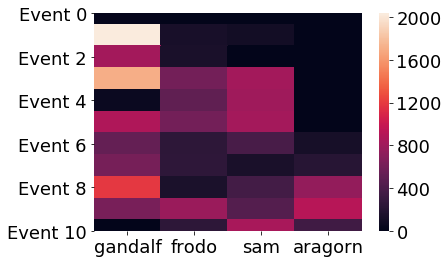

In [71]:
sns.heatmap(main_chars)